# Data Analysis

In this file, we proceed to develop and test the pipeline that handles our dataset.

Thsi specific file is dedicated to the understanding of the "cancer" dataset provided by the National Cancer Institute, CDG Data Portal.

DATASET was provided by :
https://portal.gdc.cancer.gov/

filter applied were :

- Data Type : Gene Expression Quantification
- Experimental Strategy : RNA-seq
- Access : Open
- Project : CPTAC-3

### All the imports for all the things

In [1]:
import os
import sys
import pandas as pd
import datetime


import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  






import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# for translation of gene symbols
import mygene

import pathlib
import scipy

from sklearn.preprocessing import normalize, MinMaxScaler

# to import libs 
sys.path.append('../src/utils')
import feature_selection, visualisation
sys.path.append('../src')
import data_handler



# datasets

# default path of the folder containing the salmon files
absolute_path = '/Users/aygalic/Thesis/data/cancer'  

pd.options.display.width = 1000

mg = mygene.MyGeneInfo()

### Some testing about gene name retrieval

In [6]:
# getting all folder names
entries = os.listdir(absolute_path)

# getting all file names inside folder names
files = [[absolute_path+"/"+entry+"/"+file for file in os.listdir(absolute_path+"/"+entry)] for entry in entries if os.path.isdir(absolute_path+"/"+entry)]

# keeping only .tsv
files_of_interest = [[e for e in entries if ".tsv" in e ][0] for entries in files ]

# getting rid of metadate is .tsv format that were present in the list of files
files_of_interest = [e for e in files_of_interest if "augmented_star_gene_counts" in e ]

print("Number of observations to work with:",len(files_of_interest))


Number of observations to work with: 2259


In [7]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

names = data_handler.get_names(files_of_interest[0], header = 5)
names[0:5]

0    ENSG00000000003.15
1     ENSG00000000005.6
2    ENSG00000000419.13
3    ENSG00000000457.14
4    ENSG00000000460.17
Name: N_ambiguous, dtype: object

In [ ]:
#symbols = mg.querymany(names, fields = ['genomic_pos', 'symbol'], scopes='ensembl.gene', species='human', verbose = False, as_dataframe = True)

#symbols = symbols.reset_index()
#symbols = symbols.drop_duplicates(subset = ["query"])

# WE HAVE NO SYMBOLS THAT START WITH ENSG

#[s for s in symbols["symbol"].fillna("") if s.startswith('ENSG') ]

In [7]:
#sorted_sym = symbols.sort_values(['genomic_pos.chr', 'genomic_pos.start'], ascending=[True, True])

#sorted_values = sorted_sym[['genomic_pos.chr', 'genomic_pos.start']].values
#sorted_values

### Just a bit of testing 

In [9]:
importlib.reload(feature_selection) # to allow modification of the script without restarting the whole session
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_cancer(
    feature_selection_threshold = None,
    log1p = False,
    min_max = False)

loading samples...
loaded 2259 / 2259 samples
number of genes selected :  60660
number of genes selected :  60660
shape of the dataset : (2259, 60660)
number of seq in the dataset : 2259


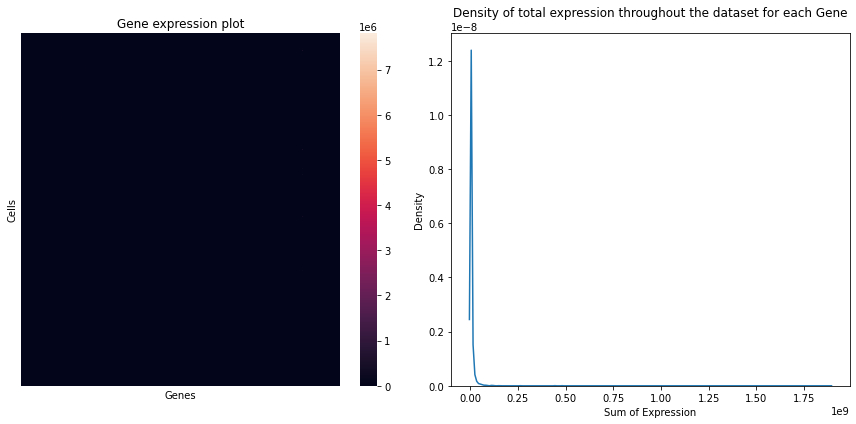

In [12]:
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
data = pd.DataFrame(data)
data.columns = gene_names
data.index = index_names
visualisation.dataset_plot(dataset)


loading samples...
loaded 2259 / 2259 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 285733.0


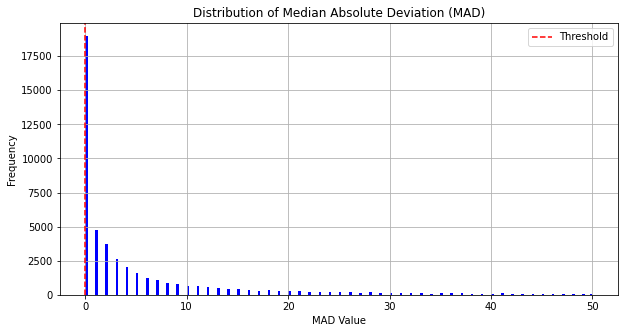

removing 31076 genes under the MAD threshold from the dataset
number of genes selected :  29584
number of genes selected :  29584
log(1 + x) transformation...
scaling to [0, 1]...
shape of the dataset : (2259, 29584)
number of seq in the dataset : 2259


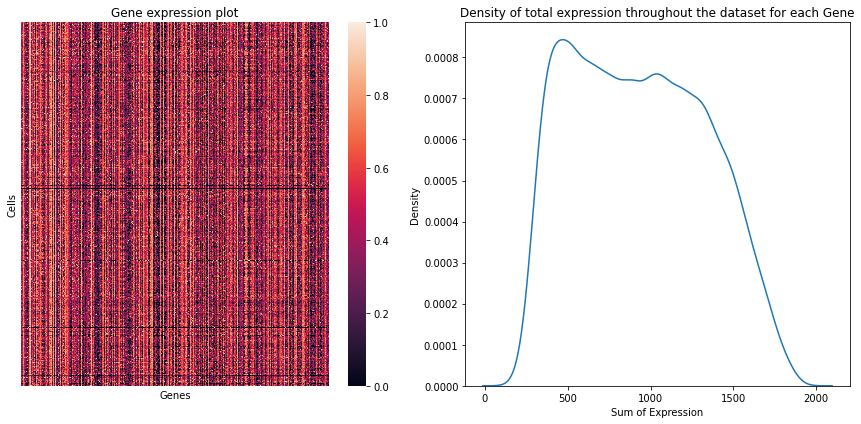

In [13]:
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset_cancer(
    feature_selection_threshold = 0,
    log1p = True,
    min_max = True)

#data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
visualisation.dataset_plot(dataset)
